In [1]:
# Cloning Git Repository to access Python Files
!git clone https://github.com/aakashvardhan/s5-pytorch-tutorial.git

fatal: destination path 's5-pytorch-tutorial' already exists and is not an empty directory.


In [2]:
'''The sys module provides access to some variables
used or maintained by the Python interpreter and to functions
that interact strongly with the interpreter. It's commonly used for
manipulating Python runtime environment, handling command-line arguments,
and system-specific parameter'''
import sys

In [3]:
# used to add a new directory to Python's list of paths where it looks for modules and packages
sys.path.append('./s5-pytorch-tutorial')

In [12]:
# Importing torchvision for handling datasets and applying transformations
from torchvision import datasets, transforms

# Importing torchsummary for displaying a summary of your PyTorch model, including the shape of the input data and the total number of parameters,
!pip install torchsummary
from torchsummary import summary

# Importing PyTorch Library
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Importing python files, including CNN model, train & test the model
from model import Net
from utils import train, test, plot_accuracy_loss_graphs

# Import the Matplotlib library for plotting
import matplotlib.pyplot as plt

In [5]:
# This block of code is used to define transformations for the training dataset.
train_transforms = transforms.Compose([
    # Randomly applies a center crop of size 22 to the input image with a probability of 0.1.
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    # Resizes the input image to a size of 28x28 pixels.
    transforms.Resize((28, 28)),
    # Randomly rotates the input image within a range of -15 to 15 degrees. The areas left after rotation are filled with 0 (black).
    transforms.RandomRotation((-15., 15.), fill=0),
    # Converts the input image to a PyTorch tensor.
    transforms.ToTensor(),
    # Normalizes the input tensor with a mean of 0.1307 and a standard deviation of 0.3081.
    transforms.Normalize((0.1307,), (0.3081,)),
])

# This block of code is used to define transformations for the testing dataset.
test_transforms = transforms.Compose([
    # Converts the input image to a PyTorch tensor.
    transforms.ToTensor(),
    # Normalizes the input tensor with a mean of 0.1407 and a standard deviation of 0.4081.
    transforms.Normalize((0.1407,), (0.4081,))
])

In [6]:
# MNIST Training dataset with specified transformation
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
# MNIST Testing dataset with specified transformation
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [7]:
# Set the batch size to 512, indicating the number of samples to be processed in one go.
batch_size = 512

# Define a dictionary of keyword arguments for the DataLoader:
# 'batch_size': Specifies the number of samples in each batch.
# 'shuffle': If True, the dataset will be shuffled at the beginning of each epoch to reduce model overfitting.
# 'num_workers': Sets the number of subprocesses to use for data loading. Utilizing multiple workers can enhance data loading throughput.
# 'pin_memory': When set to True and using a CUDA-enabled GPU, this option pins memory, potentially speeding up data transfer to the GPU.
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

# Initialize the DataLoader for the test dataset.
# 'test_data': The dataset to use for testing.
# The DataLoader handles efficient loading of data from 'test_data' using the parameters defined in 'kwargs'.
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

# Initialize the DataLoader for the training dataset.
# 'train_data': The dataset to use for training. The DataLoader will shuffle this data if 'shuffle' is True, as per 'kwargs'.
# This DataLoader facilitates efficient loading of training data, respecting the parameters specified in 'kwargs'.
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

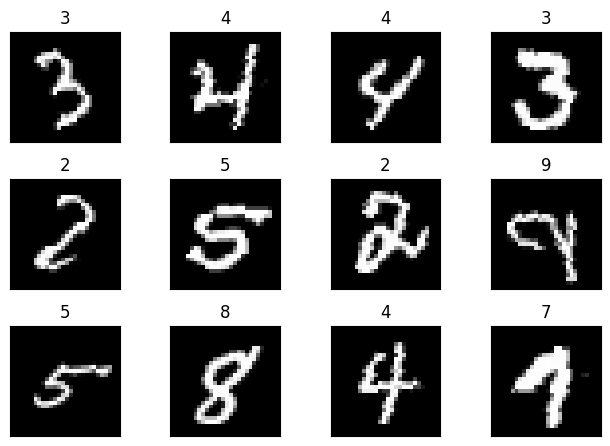

In [8]:
# Retrieve the first batch of data and labels from the training DataLoader
batch_data, batch_label = next(iter(train_loader))

# Initialize a new figure for plotting
fig = plt.figure()

# Loop over the first 12 images and labels in the batch.
for i in range(12):
  # Create a 3x4 grid of subplots. The index of the current subplot (i+1) is set to active
  plt.subplot(3,4,i+1)
  # Adjust the layout to prevent overlapping of subplot elements.
  plt.tight_layout()
  # Display an image. 'squeeze(0)' removes a dimension of size 1, which is common for grayscale images in PyTorch.
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  # Set the title of the subplot to the label of the current image. '.item()' converts a PyTorch scalar to a Python number.
  plt.title(batch_label[i].item())
  # Remove the x-axis ticks.
  plt.xticks([])
  # Remove the y-axis ticks.
  plt.yticks([])

In [9]:
# Check if CUDA is available on the system and set `use_cuda` accordingly
use_cuda = torch.cuda.is_available()

# Set the device to "cuda" if CUDA is available, otherwise fall back to using the CPU
device = torch.device("cuda" if use_cuda else "cpu")

# Initialize the model and move it to the specified device (either GPU or CPU)
model = Net().to(device)

# Display a summary of the model, including the total parameters and the shape of inputs it expects
# Here, the input size is specified as (1, 28, 28), which could represent a single-channel (grayscale) image of 28x28 pixels
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [10]:
# Initialize the model and move it to the specified device (GPU or CPU)
model = Net().to(device)

# Set up the optimizer for training. Here, we're using Stochastic Gradient Descent (SGD)
# with a learning rate of 0.01 and momentum of 0.9 for better convergence
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define a learning rate scheduler that decreases the learning rate by a factor of 0.1
# every 15 epochs to fine-tune the training in later stages
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)

# Define the loss function. Here, Negative Log Likelihood Loss is used, suitable for classification problems
criterion = F.nll_loss

# Specify the number of epochs to train the model
num_epochs = 20

# Start the training loop over the specified number of epochs
for epoch in range(1, num_epochs+1):
  # Print the current epoch number
  print(f'Epoch {epoch}')

  # Call the training function for a single epoch with the training data
  # Pass the model, device, training data loader, optimizer, and loss function as arguments
  train(model, device, train_loader, optimizer, criterion)

  # Evaluate the model with the testing data after training
  # Pass the model, device, testing data loader, and loss function as arguments
  test(model, device, test_loader, criterion)

  # Update the learning rate based on the scheduler
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.8040 Batch_id=117 Accuracy=32.28: 100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


Test set: Average loss: 0.0017, Accuracy: 7098/10000 (70.98%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1180 Batch_id=117 Accuracy=88.46: 100%|██████████| 118/118 [00:20<00:00,  5.62it/s]


Test set: Average loss: 0.0003, Accuracy: 9655/10000 (96.55%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1310 Batch_id=117 Accuracy=95.69: 100%|██████████| 118/118 [00:19<00:00,  5.94it/s]


Test set: Average loss: 0.0002, Accuracy: 9776/10000 (97.76%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0409 Batch_id=117 Accuracy=96.61: 100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


Test set: Average loss: 0.0002, Accuracy: 9780/10000 (97.80%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.1481 Batch_id=117 Accuracy=97.23: 100%|██████████| 118/118 [00:21<00:00,  5.54it/s]


Test set: Average loss: 0.0001, Accuracy: 9844/10000 (98.44%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0985 Batch_id=117 Accuracy=97.56: 100%|██████████| 118/118 [00:22<00:00,  5.34it/s]


Test set: Average loss: 0.0001, Accuracy: 9856/10000 (98.56%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0817 Batch_id=117 Accuracy=97.75: 100%|██████████| 118/118 [00:20<00:00,  5.62it/s]


Test set: Average loss: 0.0001, Accuracy: 9871/10000 (98.71%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0397 Batch_id=117 Accuracy=98.05: 100%|██████████| 118/118 [00:20<00:00,  5.76it/s]


Test set: Average loss: 0.0001, Accuracy: 9881/10000 (98.81%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.1066 Batch_id=117 Accuracy=98.21: 100%|██████████| 118/118 [00:24<00:00,  4.83it/s]


Test set: Average loss: 0.0001, Accuracy: 9896/10000 (98.96%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0383 Batch_id=117 Accuracy=98.36: 100%|██████████| 118/118 [00:20<00:00,  5.74it/s]


Test set: Average loss: 0.0001, Accuracy: 9901/10000 (99.01%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0550 Batch_id=117 Accuracy=98.51: 100%|██████████| 118/118 [00:20<00:00,  5.83it/s]


Test set: Average loss: 0.0001, Accuracy: 9904/10000 (99.04%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.1100 Batch_id=117 Accuracy=98.55: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s]


Test set: Average loss: 0.0001, Accuracy: 9911/10000 (99.11%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0142 Batch_id=117 Accuracy=98.62: 100%|██████████| 118/118 [00:22<00:00,  5.35it/s]


Test set: Average loss: 0.0001, Accuracy: 9914/10000 (99.14%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0170 Batch_id=117 Accuracy=98.75: 100%|██████████| 118/118 [00:21<00:00,  5.53it/s]


Test set: Average loss: 0.0001, Accuracy: 9910/10000 (99.10%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0089 Batch_id=117 Accuracy=98.78: 100%|██████████| 118/118 [00:21<00:00,  5.45it/s]


Test set: Average loss: 0.0001, Accuracy: 9925/10000 (99.25%)
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0056 Batch_id=117 Accuracy=98.97: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s]


Test set: Average loss: 0.0001, Accuracy: 9930/10000 (99.30%)
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0515 Batch_id=117 Accuracy=99.03: 100%|██████████| 118/118 [00:20<00:00,  5.77it/s]


Test set: Average loss: 0.0000, Accuracy: 9937/10000 (99.37%)
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0050 Batch_id=117 Accuracy=99.10: 100%|██████████| 118/118 [00:21<00:00,  5.55it/s]


Test set: Average loss: 0.0000, Accuracy: 9933/10000 (99.33%)
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0343 Batch_id=117 Accuracy=99.08: 100%|██████████| 118/118 [00:21<00:00,  5.53it/s]


Test set: Average loss: 0.0000, Accuracy: 9932/10000 (99.32%)
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0285 Batch_id=117 Accuracy=99.05: 100%|██████████| 118/118 [00:21<00:00,  5.55it/s]


Test set: Average loss: 0.0000, Accuracy: 9934/10000 (99.34%)
Adjusting learning rate of group 0 to 1.0000e-03.


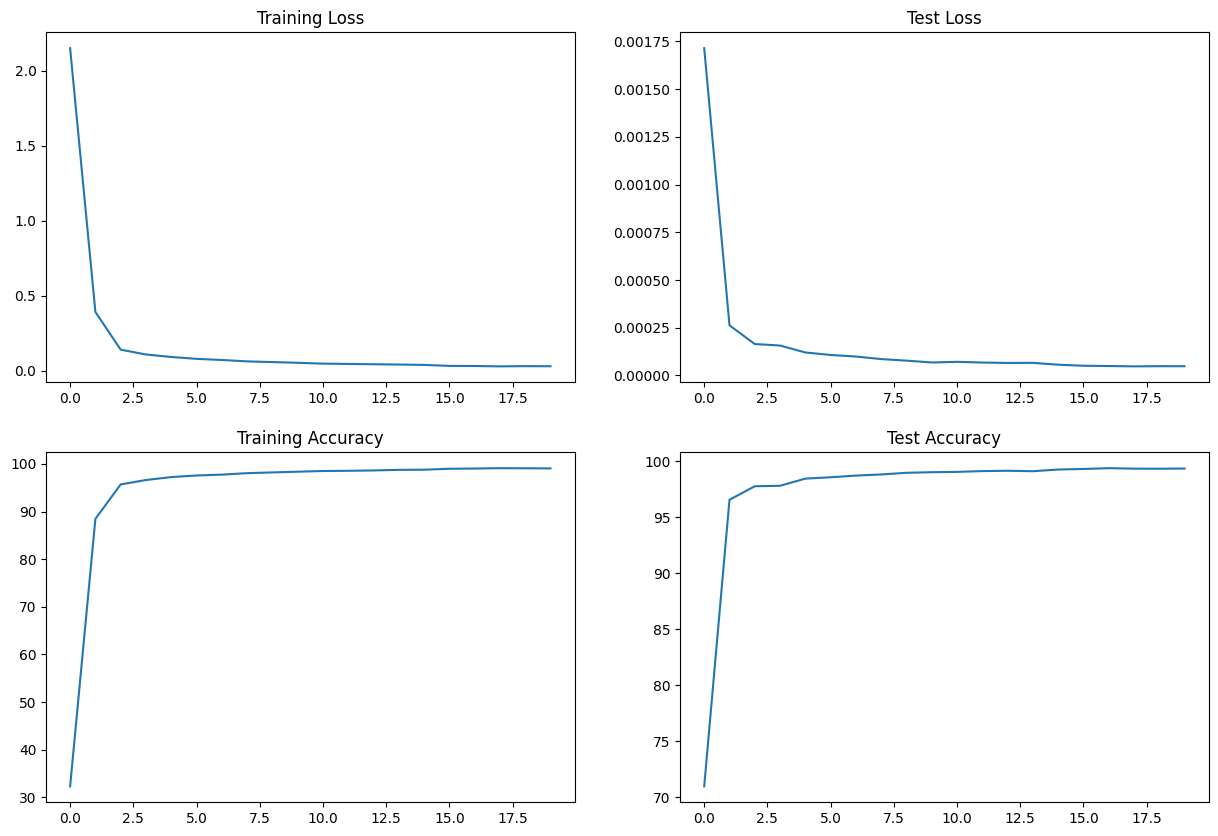

In [13]:
# Plot the Train & Test Loss and Accuracy Graph
plot_accuracy_loss_graphs()